In [1]:
import pandas as pd
from greenbutton_objects import parse
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = "XCEL_Electric_15_Minute_05-31-2022_12-22-2024.xml"
object = parse.parse_feed(file_path)

In [3]:
interval_readings = list(object[0].meterReadings)[0].intervalBlocks[0].intervalReadings
time_start = np.array([pd.to_datetime(reading.timePeriod.start, utc=True).tz_convert('MST') for reading in interval_readings])
watt_hour = np.array([reading.value for reading in interval_readings])
cost_dollars = np.array([reading.cost for reading in interval_readings])
cost_per_kwh = np.where(watt_hour != 0, cost_dollars / (watt_hour / 1000), np.nan)
cost_per_kwh = pd.Series(cost_per_kwh).fillna(method='ffill').values
print("total dollars = ", round(np.sum(cost_dollars), 0))
print("total kwh = ", round(np.sum(watt_hour) / 1000.0), 0)
print("total cost per kwh avg = ", round(np.mean(cost_per_kwh), 3))

total dollars =  2329.0
total kwh =  20397 0
total cost per kwh avg =  nan


C:\Users\wbecker\AppData\Local\Temp\ipykernel_83356\355187621.py:5: RuntimeWarning: invalid value encountered in divide
  cost_per_kwh = np.where(watt_hour != 0, cost_dollars / (watt_hour / 1000), np.nan)
C:\Users\wbecker\AppData\Local\Temp\ipykernel_83356\355187621.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cost_per_kwh = pd.Series(cost_per_kwh).fillna(method='ffill').values


In [4]:
interval_readings = list(object[0].meterReadings)[0].intervalBlocks[0].intervalReadings
time_start = np.array([pd.to_datetime(reading.timePeriod.start, utc=True).tz_convert('MST') for reading in interval_readings])

In [5]:
data = {
    'time_start': time_start,
    'watt_hour': watt_hour,
    'cost_dollars': cost_dollars,
    'cost_per_kwh': cost_per_kwh
}

df = pd.DataFrame(data).set_index('time_start')

# Read the CSV file into a dataframe
solar_df = pd.read_csv('solar_Jan23_Dec25_2024.csv', index_col=0, parse_dates=True)

# Convert the timezone of solar_df to match df
solar_df.index = solar_df.index.tz_localize('MST') #.tz_convert('MST')

# Align the datetime index and concatenate the "Energy Produced (Wh)" column
df = df.join(solar_df['Energy Produced (Wh)'], how='outer').fillna(0)
df.rename(columns={"Energy Produced (Wh)": "pv_watt_hour"}, inplace=True)

# Resample the data by hour and calculate the sum of watt_hour for each hour
hourly_sum_load = df['watt_hour'].resample('h').sum()
hourly_sum_pv = df['pv_watt_hour'].resample('h').sum()

# Broadcast the hourly sum back to the original dataframe
df['hourly_avg_power_watt'] = df.index.to_series().dt.floor('h').map(hourly_sum_load)
df['hourly_avg_pv_watt'] = df.index.to_series().dt.floor('h').map(hourly_sum_pv)

print(df["2024-01-01 00:00:00":"2024-01-02"])

                           watt_hour  cost_dollars  cost_per_kwh  \
time_start                                                         
2024-01-01 00:00:00-07:00    110.000       0.01287      0.117000   
2024-01-01 00:15:00-07:00    126.000       0.01475      0.117063   
2024-01-01 00:30:00-07:00    168.000       0.01967      0.117083   
2024-01-01 00:45:00-07:00    162.000       0.01896      0.117037   
2024-01-01 01:00:00-07:00    166.999       0.01955      0.117067   
...                              ...           ...           ...   
2024-01-02 22:45:00-07:00    299.000       0.03500      0.117057   
2024-01-02 23:00:00-07:00    302.000       0.03536      0.117086   
2024-01-02 23:15:00-07:00    193.999       0.02271      0.117062   
2024-01-02 23:30:00-07:00     95.000       0.01112      0.117053   
2024-01-02 23:45:00-07:00     77.000       0.00901      0.117013   

                           pv_watt_hour  hourly_avg_power_watt  \
time_start                                       

In [6]:
sum(df["pv_watt_hour"] / 1000.0)

10857.244

In [7]:
pvwatts_prod_kw = pd.read_csv('PVWatts Defaults 8 kW DC Home.csv', index_col=0, parse_dates=True)

# Change the year of all the "Time Stamp" index column to 2024 instead of 2023
pvwatts_prod_kw.index = pvwatts_prod_kw.index.map(lambda x: x.replace(year=2024))
# Upsample to 15-minute intervals and fill with the hourly values
pvwatts_prod_kw_15min = pvwatts_prod_kw.resample('15min').ffill()
# Remove the leap day
pvwatts_prod_kw_15min = pvwatts_prod_kw_15min[~((pvwatts_prod_kw_15min.index >= '2024-02-29 00:00:00') & (pvwatts_prod_kw_15min.index < '2024-03-01 00:00:00'))]
# Append the next three 15-minute time intervals to the end of the dataframe
additional_times = pd.date_range(start='2024-12-31 23:15:00', end='2024-12-31 23:45:00', freq='15min')
additional_data = pd.DataFrame(0, index=additional_times, columns=pvwatts_prod_kw_15min.columns)
pvwatts_prod_kw_15min = pd.concat([pvwatts_prod_kw_15min, additional_data])
pvwatts_prod_kw_15min.index = pvwatts_prod_kw_15min.index.tz_localize('MST')
print(pvwatts_prod_kw_15min.iloc[26:48,:])
len(pvwatts_prod_kw_15min)
# pvwatts_prod_kw_15min.to_csv('pvwatts_prod_kw_15min.csv', header=True)

                           pv_to_load_kw  pv_exported_kw  pv_total_kw
2024-01-01 06:30:00-07:00          0.000            0.00        0.000
2024-01-01 06:45:00-07:00          0.000            0.00        0.000
2024-01-01 07:00:00-07:00          0.000            0.00        0.000
2024-01-01 07:15:00-07:00          0.000            0.00        0.000
2024-01-01 07:30:00-07:00          0.000            0.00        0.000
2024-01-01 07:45:00-07:00          0.000            0.00        0.000
2024-01-01 08:00:00-07:00          0.012            0.00        0.012
2024-01-01 08:15:00-07:00          0.012            0.00        0.012
2024-01-01 08:30:00-07:00          0.012            0.00        0.012
2024-01-01 08:45:00-07:00          0.012            0.00        0.012
2024-01-01 09:00:00-07:00          0.486            0.00        0.486
2024-01-01 09:15:00-07:00          0.486            0.00        0.486
2024-01-01 09:30:00-07:00          0.486            0.00        0.486
2024-01-01 09:45:00-

35040

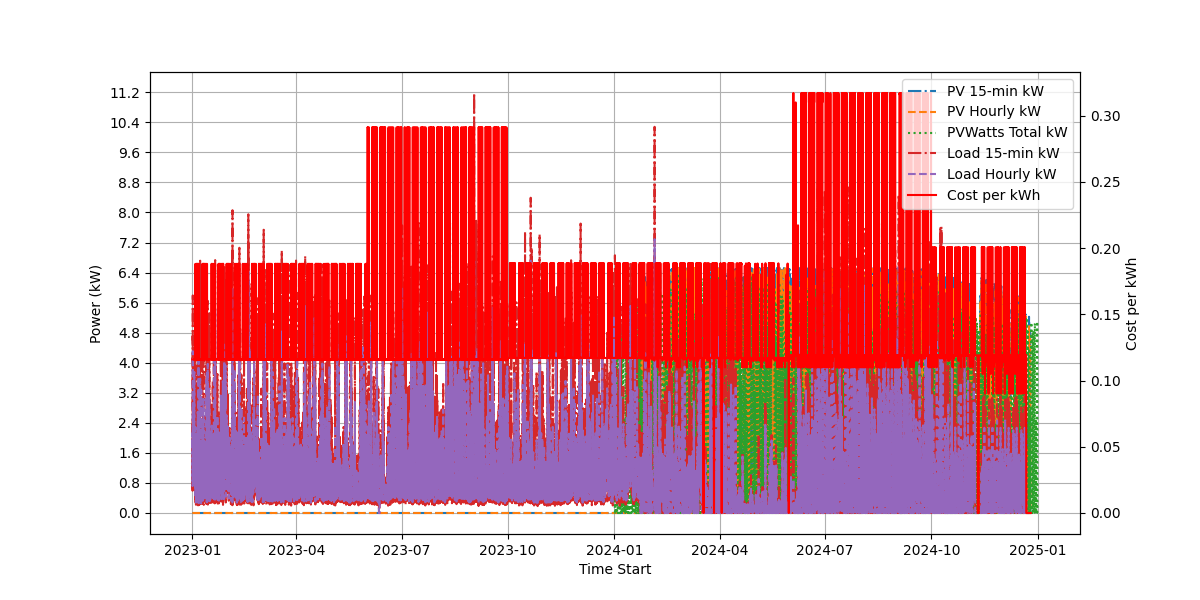

In [8]:
# Enable interactive mode
%matplotlib widget

df_yr = df.loc['2023-01-01':]
load_15_kw = df_yr['watt_hour'] / 1000 / 0.25
load_hourly_kw = df_yr['hourly_avg_power_watt'] / 1000
pv_15_kw = df_yr['pv_watt_hour'] / 1000 / 0.25
pv_hourly_kw = df_yr['hourly_avg_pv_watt'] / 1000

fig, ax1 = plt.subplots(figsize=(12, 6))

# Double the amount of y-axis tick marks
ax1.yaxis.set_major_locator(plt.MaxNLocator(nbins=20))
ax1.grid(True)

# PV 15-min and hourly-avg kW
ax1.plot(df_yr.index, pv_15_kw, label='PV 15-min kW', linestyle='-.')
ax1.plot(df_yr.index, pv_hourly_kw, label='PV Hourly kW', linestyle='--')
ax1.plot(pvwatts_prod_kw_15min.index, pvwatts_prod_kw_15min["pv_total_kw"], label='PVWatts Total kW', linestyle=':')

# Load 15-min and hourly-avg kW
ax1.plot(df_yr.index, load_15_kw, label='Load 15-min kW', linestyle='-.')
ax1.plot(df_yr.index, load_hourly_kw, label='Load Hourly kW', linestyle='--')

ax2 = ax1.twinx()
ax2.plot(df_yr.index, df_yr['cost_per_kwh'], label='Cost per kWh', color='red')

ax1.set_xlabel('Time Start')
ax1.set_ylabel('Power (kW)')
ax2.set_ylabel('Cost per kWh')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

In [9]:
# TODO confirm I have MST for the load (PV checks out compared to the Enlighten app)
# TODO see diff for REopt between PVWatts and actual PV production, estimated load profile vs actual
# TODO the PVWatts currently in here does NOT have tailored parameters like I did for SAM


df_2023 = df.loc['2023']
load_hourly_kw_2023 = df_2023['hourly_avg_power_watt'] / 1000

In [10]:
# Determine if there are gaps in the data and fill those gaps

# Calculate the time difference between consecutive rows
time_diff = load_hourly_kw_2023.index.to_series().diff()

# Find where the time difference is greater than 15 minutes
gaps = time_diff[time_diff > pd.Timedelta(minutes=15)]

# Calculate the average load value
average_load_value = load_hourly_kw_2023.mean()

# Create a new dataframe to store the filled data
filled_df = load_hourly_kw_2023.copy()

# Iterate over the gaps and fill in the missing values
for gap_end in gaps.index:
    gap_start = gap_end - gaps[gap_end] + pd.Timedelta(minutes=15)
    time_range = pd.date_range(start=gap_start, end=gap_end - pd.Timedelta(minutes=15), freq='15T')
    new_data = pd.Series(average_load_value, index=time_range)
    filled_df = pd.concat([filled_df, new_data])

# Sort the dataframe by index to maintain the correct order
filled_df = filled_df.sort_index()

len(filled_df)

C:\Users\wbecker\AppData\Local\Temp\ipykernel_83356\1047414790.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_range = pd.date_range(start=gap_start, end=gap_end - pd.Timedelta(minutes=15), freq='15T')


35040

In [11]:
# Downsample the data to hourly resolution
load_hourly_kw_2023_8760 = filled_df[::4]
load_hourly_kw_2023_8760.index = range(1, len(load_hourly_kw_2023_8760) + 1)
load_hourly_kw_2023_8760.index.name = 'Hour'
load_hourly_kw_2023_8760.name = 'Electric Load (kW)'
load_hourly_kw_2023_8760.to_frame().to_csv('load_hourly_kw_2023.csv', header=True)